# Predicting Formation Energies using *Ward 2016* and *Deml 2015* Methods

This notebook predicts formation energies of a set of compounds using the method described in [*Ward 2016*](https://www.nature.com/articles/npjcompumats201628) and compares the results to values computed using the [*Deml 2016*](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.93.085142) Method on the same set of compounds.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import pandas as pd
import matminer

%matplotlib inline

## Training Set
The training set is a set of ~2000 compounds with formation energies taken from the Open Quantum Materials Database (OQMD)

In [2]:
training_set = pd.read_csv("datasets/deml_dataset.csv")
training_set

,composition,delta_e
0,As1Y1,-1.555732
1,Ga1P1,-0.534169
2,Ga2Mg1S4,-1.068504
3,Cd4K1O12V3,-1.968765
4,Al1Ca1Fe1Na1O12Si4,-2.949067
5,Hf1O3Pb1,-2.830320
6,Al2Ba2Co1F14Mn1,-3.488390
7,Ba2Cd1F14Fe2Mn1,-3.007836
8,Be2O4Si1,-3.020793
9,Ba2Ca1Cu1F14Ga2,-3.325601


## Compute descriptors MatMiner
This uses the MatMiner implementation of the *Ward 2016* method to compute 145 composition based attributes.

In [3]:
from matminer.descriptors import composition as cp
from pymatgen import Composition

import time
start = time.time()
def calc_attributes(training_set):
    training_set_updated = cp.StoichiometricAttribute().featurize_all(training_set)
    training_set_updated = cp.ElementalAttribute().featurize_all(training_set_updated)
    training_set_updated = cp.ValenceOrbitalAttribute().featurize_all(training_set_updated)
    training_set_updated = cp.IonicAttribute().featurize_all(training_set_updated)
    
    return training_set_updated

#%lprun -f calc_attributes calc_attributes()

all_descriptors = calc_attributes(training_set)
print np.shape(all_descriptors)
print "Featurization time: %f "%(time.time() - start)

(2338, 147)
Featurization time: 5.543758 


In [4]:
#Columns not containing descriptors
cols_to_drop = ["composition", "delta_e"]

## Classification: Negative vs. Positive Formation Energy

Here, we use a random forest classifier model to predict whether a compound will have a negative or positive formation energy.

In [5]:
#Discretize into positive/negative formation energy

delta_e = np.array(training_set["delta_e"], dtype=float)
energy_range = np.zeros(np.shape(delta_e), dtype=str)

for i in range(len(delta_e)):
    if delta_e[i] < 0:
        energy_range[i] = "neg"
    else:
        energy_range[i] = "pos"
        
print energy_range

['n' 'n' 'n' ..., 'p' 'n' 'n']


In [6]:
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier()
model1.fit(all_descriptors.drop(cols_to_drop, axis=1), energy_range)
prediction = model1.predict(all_descriptors.drop(cols_to_drop, axis=1))

Comparison of predicted vs actual energy classification

In [7]:
pd.crosstab(energy_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,2323,0
p,5,10


## Regression: Predicting Formation Energy
Next, we use Random Forest Regression to predict formation energy values.

In [8]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(all_descriptors.drop(cols_to_drop, axis=1), delta_e)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [9]:
prediction = rf_model.predict(all_descriptors.drop(cols_to_drop, axis=1))

This is a plot of OQMD Data vs predicted values.

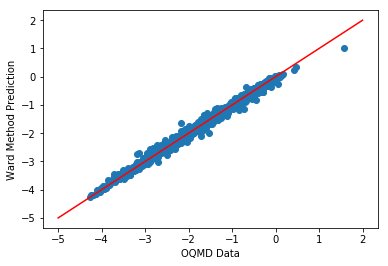

In [10]:
plt.scatter(delta_e, prediction)
plt.plot(range(-5,3), range(-5,3), 'r')
#plt.axis([-20,20,-20,20])
plt.xlabel("OQMD Data")
plt.ylabel("Ward Method Prediction")

Next, we cross-validate the model using k-fold cross validation. For reference, *Deml 2015* reported a cross-validation error of ~0.08 eV/atom.

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

errors = cross_val_score(RandomForestRegressor(), all_descriptors.drop(cols_to_drop, axis=1), delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.122035948614


Mean absolute difference between OQMD values and predicted values

In [12]:
np.mean(np.abs(delta_e-prediction))

0.044875027185696408

## Compare to Model 1 from *Deml 2015*
This dataset contains predicted formation energies generated using Deml's [predict_Etot_dHf](https://github.com/ademl/predict_Etot_dHf) code.

In [13]:
dHf_deml = pd.read_csv("datasets/deml_predictions.csv")
dHf_deml

,composition,dHf
0,As1Y1,-1.616769
1,Ga1P1,-0.169276
2,Ga2Mg1S4,-1.257402
3,Cd4K1O12V3,-2.094023
4,Al1Ca1Fe1Na1O12Si4,NaN
5,Hf1O3Pb1,-2.537457
6,Al2Ba2Co1F14Mn1,NaN
7,Ba2Cd1F14Fe2Mn1,NaN
8,Be2O4Si1,-3.433094
9,Ba2Ca1Cu1F14Ga2,-3.155456


In [14]:
#Drop NaN values
dHf_deml = dHf_deml.assign(oqmd_data=delta_e, ward_npj=prediction)
dHf_deml = dHf_deml.dropna()
dHf_deml

,composition,dHf,oqmd_data,ward_npj
0,As1Y1,-1.616769,-1.555732,-1.437602
1,Ga1P1,-0.169276,-0.534169,-0.485981
2,Ga2Mg1S4,-1.257402,-1.068504,-1.100613
3,Cd4K1O12V3,-2.094023,-1.968765,-2.168807
5,Hf1O3Pb1,-2.537457,-2.830320,-2.532954
8,Be2O4Si1,-3.433094,-3.020793,-3.058744
9,Ba2Ca1Cu1F14Ga2,-3.155456,-3.325601,-3.324816
10,Ge1O4Zn2,-1.984194,-1.809053,-1.740176
11,Ca1Cr1F7Sr1,-3.332806,-3.707430,-3.596179
12,As3Ga1Na6,-0.515935,-0.523152,-0.520210


This is a plot of OQMD Data vs. Deml method predictions.

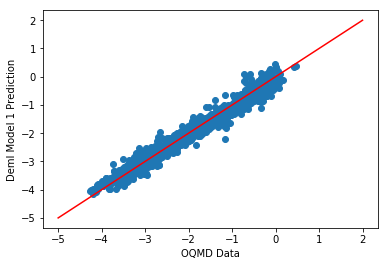

In [15]:
plt.scatter(dHf_deml["oqmd_data"], dHf_deml["dHf"])
plt.plot(range(-5,3), range(-5,3), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Deml Model 1 Prediction")

Mean absolute difference between OQMD values and predicted values

In [16]:
np.mean(np.abs(dHf_deml["dHf"]-dHf_deml["oqmd_data"]))

0.13436403065486335

This is a plot of Ward method vs. Deml method predictions.

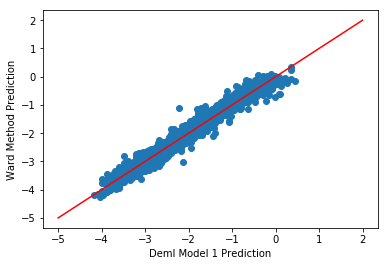

In [17]:
plt.scatter(dHf_deml["dHf"], dHf_deml["ward_npj"])
plt.plot(range(-5,3), range(-5,3), 'r')
plt.xlabel("Deml Model 1 Prediction")
plt.ylabel("Ward Method Prediction")

Mean absolute difference between Ward method predictions and Deml method predictions

In [18]:
np.mean(np.abs(dHf_deml["dHf"]-dHf_deml["ward_npj"]))

0.1379563049371895